In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import numpy.matlib
from sklearn.utils import resample

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, get_fdr_p, run_pheno_correlations, prop_bar_plot, get_fdr_p_df, get_sys_prop, update_progress, dependent_corr, my_get_cmap

In [4]:
train_test_str = 'train_test'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)
    
outputdir = os.path.join(os.environ['PIPELINEDIR'], '6_results_correlations', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs
/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline/6_results_correlations/out


## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('psych_phenos')

phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall psychopathology','Psychosis (positive)','Psychosis (negative)','Anxious-misery','Externalizing','Fear']
metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Load data

In [8]:
load = 'test'

In [9]:
if load == 'all':
    # Train
    df_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'train.csv'))
    df_train.set_index(['bblid', 'scanid'], inplace = True)
    df_node_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_train.csv'))
    df_node_train.set_index(['bblid', 'scanid'], inplace = True)

    # Test
    df_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
    df_test.set_index(['bblid', 'scanid'], inplace = True)
    df_node_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
    df_node_test.set_index(['bblid', 'scanid'], inplace = True)

    # concat
    df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
    df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)
elif load == 'test':
    # Test
    df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
    df.set_index(['bblid', 'scanid'], inplace = True); print(df.shape)
    df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
    df_node.set_index(['bblid', 'scanid'], inplace = True); print(df_node.shape)

(1068, 49)
(1068, 800)


## Load nispat outputs

In [10]:
if load == 'all':
    z_cv = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out_cv', 'Z.txt'), delimiter = ' ').transpose()
    df_z_cv = pd.DataFrame(data = z_cv, index = df_node_train.index, columns = df_node_train.columns)

    z = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'Z.txt'), delimiter = ' ').transpose()
    df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns)

    # concat
    df_z = pd.concat((df_z_cv,df_z_test), axis = 0); print(df_z.shape)
elif load == 'test':
    z = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'Z.txt'), delimiter = ' ').transpose()
    df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns); print(df_z.shape)

(1068, 800)


### Regress age/sex out of psychopathology phenotypes

In [11]:
# df_nuis = df.loc[:,['ageAtScan1_Years','sex_adj']]
# # df_nuis = df.loc[:,['ageAtScan1_Years','sex_adj','medu1']]
# # df_nuis = df.loc[:,'medu1']
# df_nuis = sm.add_constant(df_nuis)

# mdl = sm.OLS(df.loc[:,phenos], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = phenos
# df.loc[:,phenos] = df.loc[:,phenos] - y_pred

# Note, regressing out age/sex from the deviations as well as the phenotypes makes no difference to the results
# # df_z
# cols = df_z.columns
# mdl = sm.OLS(df_z.loc[:,cols], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = cols
# df_z.loc[:,cols] = df_z.loc[:,cols] - y_pred

## Setup region filter
### regions with SMSE <1 in normative model

In [12]:
smse = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

In [13]:
smse_thresh = 1
region_filter = df_smse.iloc[:,0] < smse_thresh

In [14]:
region_filter.sum()

750

## Get pheno-nispat relationships

In [15]:
# region_filter = region_filter.filter(regex = 'vol')
# region_filter.sum()

In [16]:
# # drop thickness
# df_node = df_node.filter(regex = 'vol'); print(df_node.shape)
# df_z = df_z.filter(regex = 'vol'); print(df_z.shape)

### Regional

In [17]:
method = 'pearson'

In [18]:
assign_p = 'parametric' # 'permutation' 'parametric'
if parc_str == 'lausanne':
    assign_p = 'parametric'

In [19]:
if assign_p == 'permutation':
    nulldir = os.path.join(os.environ['NORMATIVEDIR'], 'nulls_z')
#     nulldir = os.path.join(os.environ['NORMATIVEDIR'], 'nulls_z_agesex')
    if not os.path.exists(nulldir): os.makedirs(nulldir)
    df_pheno_z = run_pheno_correlations(df.loc[:,phenos], df_z, method = method, assign_p = assign_p, nulldir = nulldir)
elif assign_p == 'parametric':
    df_pheno_z = run_pheno_correlations(df.loc[:,phenos], df_z, method = method, assign_p = assign_p)

In [20]:
# correct multiple comparisons. We do this across brain regions and phenotypes (e.g., 400*6 = 2400 tests)
df_p_corr = pd.DataFrame(index = df_pheno_z.index, columns = ['p-corr']) # output dataframe

for metric in metrics:
    p_corr = get_fdr_p(df_pheno_z.loc[:,'p'].filter(regex = metric)) # correct p-values for metric
    p_corr_tmp = pd.DataFrame(index = df_pheno_z.loc[:,'p'].filter(regex = metric).index, columns = ['p-corr'], data = p_corr) # set to dataframe with correct indices
    df_pheno_z.loc[p_corr_tmp.index, 'p-corr'] = p_corr_tmp # store using index matching

In [21]:
for pheno in phenos:
    for metric in metrics:
        print(pheno, metric, np.sum(df_pheno_z.filter(regex = metric, axis = 0).filter(regex = pheno, axis = 0).loc[:,'p-corr'] < .05) / num_parcels * 100, '% significant effects (fdr)')
    print('')

Overall_Psychopathology ct 2.5 % significant effects (fdr)
Overall_Psychopathology vol 26.75 % significant effects (fdr)

Psychosis_Positive ct 2.75 % significant effects (fdr)
Psychosis_Positive vol 9.0 % significant effects (fdr)

Psychosis_NegativeDisorg ct 0.0 % significant effects (fdr)
Psychosis_NegativeDisorg vol 0.25 % significant effects (fdr)

AnxiousMisery ct 0.0 % significant effects (fdr)
AnxiousMisery vol 0.25 % significant effects (fdr)

Externalizing ct 0.25 % significant effects (fdr)
Externalizing vol 2.25 % significant effects (fdr)

Fear ct 2.0 % significant effects (fdr)
Fear vol 8.25 % significant effects (fdr)



In [22]:
alpha = 0.05
print(alpha)

0.05


In [23]:
x = df_pheno_z['p-corr'].values < alpha
df_pheno_z['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(region_filter, 1, len(phenos))

my_bool = np.concatenate((x, y), axis = 0); region_filt = np.all(my_bool, axis = 0); df_pheno_z['sig_smse'] = region_filt

print(str(np.sum(df_pheno_z['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_smse'] == True)) + ' significant effects (fdr)')

217 significant effects (fdr)
206 significant effects (fdr)


In [24]:
for pheno in phenos:
    for metric in metrics:
#         print(pheno, metric, np.sum(df_pheno_z.loc[pheno,'sig_smse'].filter(regex = metric) == True) / num_parcels * 100, '% significant effects (fdr)')
        print(pheno, metric, np.sum(df_pheno_z.loc[pheno,'sig'].filter(regex = metric) == True) / num_parcels * 100, '% significant effects (fdr)')
    print('')

Overall_Psychopathology ct 2.5 % significant effects (fdr)
Overall_Psychopathology vol 26.75 % significant effects (fdr)

Psychosis_Positive ct 2.75 % significant effects (fdr)
Psychosis_Positive vol 9.0 % significant effects (fdr)

Psychosis_NegativeDisorg ct 0.0 % significant effects (fdr)
Psychosis_NegativeDisorg vol 0.25 % significant effects (fdr)

AnxiousMisery ct 0.0 % significant effects (fdr)
AnxiousMisery vol 0.25 % significant effects (fdr)

Externalizing ct 0.25 % significant effects (fdr)
Externalizing vol 2.25 % significant effects (fdr)

Fear ct 2.0 % significant effects (fdr)
Fear vol 8.25 % significant effects (fdr)



In [25]:
metrics = ['vol',]
metrics_label_short = ['Volume',]
metrics_label = ['Volume',]

In [26]:
metric = metrics[0]; print(metric)

vol


In [27]:
vals = np.zeros(len(phenos))

for p, pheno in enumerate(phenos):
#     vals[p] = np.sum(df_pheno_z.loc[pheno,'sig_smse'].filter(regex = metric) == True) / num_parcels * 100
    vals[p] = np.sum(df_pheno_z.loc[pheno,'sig'].filter(regex = metric) == True) / num_parcels * 100

idx_perc_sig = np.argsort(vals)[::-1]

phenos_ordered = [phenos[i] for i in idx_perc_sig]
phenos_label_ordered = [phenos_label[i] for i in idx_perc_sig]

phenos_ordered

['Overall_Psychopathology',
 'Psychosis_Positive',
 'Fear',
 'Externalizing',
 'AnxiousMisery',
 'Psychosis_NegativeDisorg']

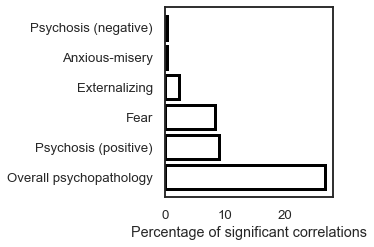

In [28]:
sns.set(style='white', context = 'talk', font_scale = 0.8)
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(3.5)

ax.barh(y = np.arange(len(phenos)), width = vals[idx_perc_sig], color = 'white', edgecolor = 'black', linewidth = 3)
ax.set_yticks(np.arange(len(phenos)))
ax.set_yticklabels(phenos_label_ordered)
ax.set_xlabel('Percentage of significant correlations')
f.savefig(outfile_prefix+'percent_sig_corrs', dpi = 100, bbox_inches = 'tight', pad_inches = 0)

## Save out

In [29]:
df.to_csv(os.path.join(outputdir,outfile_prefix+'df.csv'))
df_z.to_csv(os.path.join(outputdir,outfile_prefix+'df_z.csv'))
df_pheno_z.to_csv(os.path.join(outputdir,outfile_prefix+'df_pheno_z.csv'))
region_filter.to_csv(os.path.join(outputdir,outfile_prefix+'region_filter.csv'))

# Plots

In [30]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

Notebook initialized with png backend.


In [31]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

## a-priori regions of interest

In [32]:
# Schaefer 200
if parc_scale == 200:
    dacc_strs = ['17Networks_LH_SalVentAttnB_PFCmp_1', '17Networks_LH_ContA_Cinga_1',
                 '17Networks_RH_SalVentAttnB_PFCmp_1', '17Networks_RH_ContA_Cinga_1', '17Networks_RH_DefaultA_PFCm_2'] # daCC
    mofc_strs = ['17Networks_LH_Limbic_OFC_1', '17Networks_LH_Limbic_OFC_2', '17Networks_LH_DefaultA_PFCm_1',
                 '17Networks_RH_Limbic_OFC_1', '17Networks_RH_Limbic_OFC_2', '17Networks_RH_Limbic_OFC_3'] # vmPFC/mOFC
    insula_strs = ['17Networks_LH_SalVentAttnA_Ins_1', '17Networks_LH_SalVentAttnA_Ins_2', '17Networks_LH_SalVentAttnA_Ins_3',
                  '17Networks_RH_SalVentAttnA_Ins_1', '17Networks_RH_SalVentAttnA_Ins_2', '17Networks_RH_SalVentAttnA_Ins_3']
    inftemp_strs = ['17Networks_LH_Limbic_TempPole_1', '17Networks_LH_Limbic_TempPole_2', '17Networks_LH_Limbic_TempPole_3', '17Networks_LH_Limbic_TempPole_4',
                    '17Networks_LH_ContB_Temp_1',
                    '17Networks_LH_DefaultB_Temp_1', '17Networks_LH_DefaultB_Temp_2', '17Networks_LH_DefaultB_Temp_3', '17Networks_LH_DefaultB_Temp_4',
                    '17Networks_RH_Limbic_TempPole_1', '17Networks_RH_Limbic_TempPole_2', '17Networks_RH_Limbic_TempPole_3','17Networks_RH_Limbic_TempPole_4',
                    '17Networks_RH_ContB_Temp_1', '17Networks_RH_ContB_Temp_2',
                    '17Networks_RH_DefaultB_Temp_1', '17Networks_RH_DefaultB_AntTemp_1']

    mask_strs = {'mOFC': mofc_strs,
                 'Inf. temporal': inftemp_strs,
                 'daCC': dacc_strs,
                 'Insula': insula_strs}
elif parc_scale == 400:
    dacc_strs = ['17Networks_LH_SalVentAttnB_PFCmp_1', '17Networks_LH_DefaultA_PFCm_6', '17Networks_LH_ContA_Cinga_1',
                 '17Networks_RH_SalVentAttnB_PFCmp_1', '17Networks_RH_SalVentAttnB_PFCmp_2', '17Networks_RH_DefaultA_PFCm_6', '17Networks_RH_ContA_Cinga_1'] # daCC
    mofc_strs = ['17Networks_LH_Limbic_OFC_1', '17Networks_LH_Limbic_OFC_2', '17Networks_LH_Limbic_OFC_3', '17Networks_LH_Limbic_OFC_4', '17Networks_LH_Limbic_OFC_5', '17Networks_LH_SalVentAttnB_OFC_1',
                 '17Networks_RH_Limbic_OFC_1', '17Networks_RH_Limbic_OFC_2', '17Networks_RH_Limbic_OFC_3', '17Networks_RH_Limbic_OFC_4', '17Networks_RH_Limbic_OFC_5', '17Networks_RH_Limbic_OFC_6'] # vmPFC/mOFC
    insula_strs = ['17Networks_LH_SalVentAttnA_Ins_1', '17Networks_LH_SalVentAttnA_Ins_2', '17Networks_LH_SalVentAttnA_Ins_3',
                  '17Networks_LH_SalVentAttnA_Ins_4', '17Networks_LH_SalVentAttnA_Ins_5', '17Networks_LH_SalVentAttnA_Ins_6'
                  '17Networks_RH_SalVentAttnA_Ins_1', '17Networks_RH_SalVentAttnA_Ins_2', '17Networks_RH_SalVentAttnA_Ins_3', '17Networks_RH_SalVentAttnA_Ins_4',
                  '17Networks_RH_SalVentAttnA_Ins_5', '17Networks_RH_SalVentAttnA_Ins_6', '17Networks_RH_SalVentAttnA_Ins_7']
    inftemp_strs = ['17Networks_LH_Limbic_TempPole_1', '17Networks_LH_Limbic_TempPole_2', '17Networks_LH_Limbic_TempPole_3', '17Networks_LH_Limbic_TempPole_4',
                    '17Networks_LH_Limbic_TempPole_5', '17Networks_LH_Limbic_TempPole_6', '17Networks_LH_Limbic_TempPole_7',
                    '17Networks_LH_ContB_Temp_1',
                    '17Networks_LH_DefaultB_Temp_1', '17Networks_LH_DefaultB_Temp_2', '17Networks_LH_DefaultB_Temp_3', '17Networks_LH_DefaultB_Temp_4', '17Networks_LH_DefaultB_Temp_5', '17Networks_LH_DefaultB_Temp_6',
                    '17Networks_RH_Limbic_TempPole_1', '17Networks_RH_Limbic_TempPole_2', '17Networks_RH_Limbic_TempPole_3',
                    '17Networks_RH_Limbic_TempPole_4', '17Networks_RH_Limbic_TempPole_5', '17Networks_RH_Limbic_TempPole_6',
                    '17Networks_RH_ContB_Temp_1', '17Networks_RH_ContB_Temp_2',
                    '17Networks_RH_DefaultA_Temp_1', '17Networks_RH_DefaultB_Temp_1', '17Networks_RH_DefaultB_Temp_2', '17Networks_RH_DefaultB_AntTemp_1']

    mask_strs = {'mOFC': mofc_strs,
                 'Inf. temporal': inftemp_strs,
                 'daCC': dacc_strs,
                 'Insula': insula_strs}

In [33]:
mask = np.zeros(parcel_names.shape).astype(bool)

for roi in mask_strs.keys():
    # create mask
    mask = np.zeros(parcel_names.shape).astype(bool)
    for i, mask_str in enumerate(mask_strs[roi]):
        mask[np.where(parcel_names == mask_str)[0]] = True

    mask = mask.astype(float)
    mask[mask == False] = -1000
        
    for hemi in ['lh', 'rh']:
        if subject_id == 'lausanne125':
            parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
        elif subject_id == 'fsaverage':
            parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

        # project subject's data to vertices
        brain_plot(mask, parcel_names, parc_file, hemi+'_'+roi, subject_id = subject_id, hemi = hemi, surf = 'inflated', color = 'coolwarm', center_anchor = 3)

3
3
3
3
3
3
3
3


In [34]:
mask_strs.keys()

dict_keys(['mOFC', 'Inf. temporal', 'daCC', 'Insula'])

In [35]:
r_vals = pd.DataFrame(index = phenos, columns = mask_strs.keys())
p_vals = pd.DataFrame(index = phenos, columns = mask_strs.keys())

for pheno in phenos:
    for roi in mask_strs.keys():
        # create mask
        mask = np.zeros(parcel_names.shape).astype(bool)
        for mask_str in mask_strs[roi]:
            mask[np.where(parcel_names == mask_str)[0]] = True
            
        x = df_z.filter(regex = metric).loc[:,mask].mean(axis = 1) # get region average deviations
        y = df.loc[:,pheno]
        r_vals.loc[pheno,roi] = sp.stats.pearsonr(x,y)[0]
        p_vals.loc[pheno,roi] = sp.stats.pearsonr(x,y)[1]
p_vals = get_fdr_p_df(p_vals)
        
r_vals.index = phenos_label

In [36]:
np.round(r_vals.astype(float),2)

,mOFC,Inf. temporal,daCC,Insula
Overall psychopathology,-0.10,-0.16,-0.10,-0.08
Psychosis (positive),-0.06,-0.07,-0.07,-0.07
Psychosis (negative),0.00,-0.02,-0.01,-0.02
Anxious-misery,0.01,0.04,-0.01,0.01
Externalizing,-0.04,-0.01,-0.03,-0.04
Fear,-0.06,-0.10,-0.03,-0.11


In [37]:
p_vals<.05

,mOFC,Inf. temporal,daCC,Insula
Overall_Psychopathology,True,True,True,True
Psychosis_Positive,False,False,False,False
Psychosis_NegativeDisorg,False,False,False,False
AnxiousMisery,False,False,False,False
Externalizing,False,False,False,False
Fear,False,True,False,True


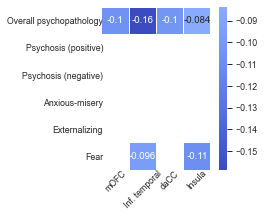

In [38]:
sns.set(style='white', context = 'paper', font_scale = 1)
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(3)

mask = np.zeros_like(r_vals)
mask[p_vals>=.05] = True

sns.heatmap(r_vals.astype(float), mask=mask, center=0, cmap='coolwarm', annot=True, linewidth=.1, square=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.tick_params(pad = -6)
f.savefig(outfile_prefix+'roi_correlations.png', dpi = 300, bbox_inches = 'tight')

In [39]:
if os.path.exists(os.path.join(outputdir,outfile_prefix+'r_bs.npy')):
    r_bs = np.load(os.path.join(outputdir,outfile_prefix+'r_bs.npy')) 
else: # otherwise, compute and save it out
    n_boot = 10000
    r_bs = np.zeros((n_boot, len(mask_strs), len(phenos)-1))

    for i in np.arange(n_boot):
        update_progress(i/n_boot)

        for j, roi in enumerate(mask_strs.keys()):
            # create mask
            mask = np.zeros(parcel_names.shape).astype(bool)
            for mask_str in mask_strs[roi]:
                mask[np.where(parcel_names == mask_str)[0]] = True

            x = df_z.filter(regex = metric).loc[:,mask].mean(axis = 1) # get region average deviations
            x_bs, df_bs = resample(x, df, n_samples = int(x.shape[0]), random_state = i, replace=True) # get boot sample
            xy = np.abs(sp.stats.pearsonr(x_bs, df_bs.loc[:,phenos[0]])[0]) # correlation between deviations (x) and phenotype (y)

            for k, pheno in enumerate(phenos[1:]):
                xz = np.abs(sp.stats.pearsonr(x_bs, df_bs.loc[:,pheno])[0]) # correlation between deviations (x) and phenotype (z)
                d = xy-xz
                r_bs[i,j,k] = d
    update_progress(1)

    np.save(os.path.join(outputdir,outfile_prefix+'r_bs'), r_bs)

In [40]:
alpha = 0.05/r_bs.shape[2]
# alpha = 0.05
print(alpha)
print(alpha/2*100)
print(100-alpha/2*100)
for j, roi in enumerate(mask_strs.keys()):
    for k, pheno in enumerate(phenos[1:]):
        lower = np.percentile(r_bs[:,j,k], alpha/2*100)
        upper = np.percentile(r_bs[:,j,k], 100-alpha/2*100)
        if lower > 0:
            print(roi,pheno,np.mean(r_bs[:,j,k]),lower,upper)

0.01
0.5
99.5
Inf. temporal Psychosis_NegativeDisorg 0.12879799794061086 0.026686020566966354 0.22006953990612715
Inf. temporal AnxiousMisery 0.11325502705841886 0.005858983099934535 0.21243360614157275
Inf. temporal Externalizing 0.13191231764774639 0.027738296665092164 0.22302006322677528


mOFC
Inf. temporal
daCC
Insula


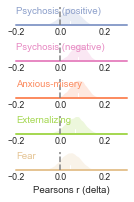

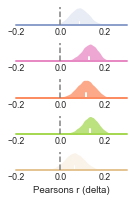

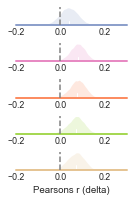

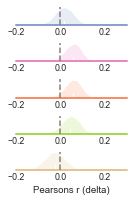

In [41]:
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('psych_phenos')
cmap = cmap[1:]

for j, roi in enumerate(mask_strs.keys()):
    print(roi)
    f, ax = plt.subplots(len(phenos)-1,1)
    f.set_figwidth(2)
    f.set_figheight(3)

    for k, pheno in enumerate(phenos[1:]):
        lower = np.percentile(r_bs[:,j,k], alpha/2*100)
        upper = np.percentile(r_bs[:,j,k], 100-alpha/2*100)

        if lower>0:
            sns.kdeplot(x=r_bs[:,j,k], ax=ax[k], bw_adjust=.75, clip_on=False, color=cmap[k], alpha=0.75, linewidth=0, fill=True)
#             sns.kdeplot(x=r_bs[:,j,k], ax=ax[k], bw_adjust=.75, clip_on=False, color="gray", alpha=1, linewidth=2)
            # add point estimate
            ax[k].axvline(x=r_bs[:,j,k].mean(), ymax=0.25, clip_on=False, color='w', linewidth=2)
        else:
            sns.kdeplot(x=r_bs[:,j,k], ax=ax[k], bw_adjust=.75, clip_on=False, color=cmap[k], alpha=0.2, linewidth=0, fill=True)
            ax[k].axvline(x=r_bs[:,j,k].mean(), ymax=0.25, clip_on=False, color='w', linewidth=1)

        ax[k].set_xlim([-.2, .3])
        ax[k].axhline(y=0, linewidth=2, clip_on=False, color=cmap[k])
        ax[k].axvline(x=0, ymax=1, clip_on=False, color='gray', linestyle='--', linewidth=1.5)

        for spine in ax[k].spines.values():
            spine.set_visible(False)
        ax[k].set_ylabel('')
        ax[k].set_yticklabels([])
        ax[k].set_yticks([])
    #     if k != len(phenos)-2:
    #         ax[k].set_xticklabels([])

        ax[k].set_xlabel('')
        ax[k].tick_params(pad = -2)
        if j == 0:
            ax[k].text(0, .75, phenos_label[1:][k], fontweight="regular", color=cmap[k],
                    ha="left", va="center", transform=ax[k].transAxes)

    ax[-1].set_xlabel('Pearson''s r (delta)')
    f.subplots_adjust(hspace=1)
#     f.suptitle(roi)
    f.savefig(outfile_prefix+'r_bs_'+roi.replace('. ','_')+'.svg', dpi = 600, bbox_inches = 'tight')

## Figure 3

In [42]:
figs_to_delete = []

for pheno in phenos:
    for metric in metrics:
        for hemi in ('lh', 'rh'):
            print(pheno, metric)
            # Plots of univariate pheno correlation
            fig_str = hemi + '_' + pheno + '_' + metric + '_z'
            figs_to_delete.append('ventral_'+fig_str)
            figs_to_delete.append('med_'+fig_str)
            figs_to_delete.append('lat_'+fig_str)

            roi_data = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
#             sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_smse']
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig']
            roi_data[~sig] = -1000

            if subject_id == 'lausanne125':
                parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            elif subject_id == 'fsaverage':
                parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            # project subject's data to vertices
            brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', center_anchor = 0.2)

Overall_Psychopathology vol
0.2
Overall_Psychopathology vol
0.2
Psychosis_Positive vol
0.2
Psychosis_Positive vol
0.2
Psychosis_NegativeDisorg vol
0.2
Psychosis_NegativeDisorg vol
AnxiousMisery vol
0.2
AnxiousMisery vol
Externalizing vol
0.2
Externalizing vol
0.2
Fear vol
0.2
Fear vol
0.2


Overall_Psychopathology
vol


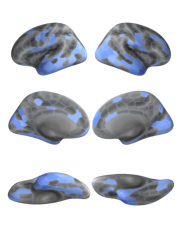

Psychosis_Positive
vol


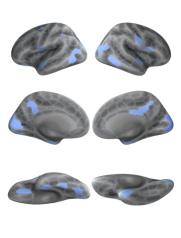

Psychosis_NegativeDisorg
vol


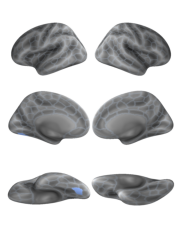

AnxiousMisery
vol


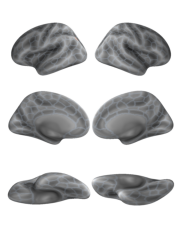

Externalizing
vol


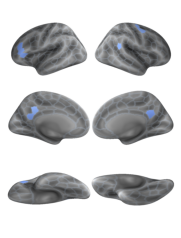

Fear
vol


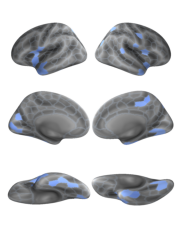

In [43]:
for pheno in phenos:
    for metric in metrics:
        f, axes = plt.subplots(3, 2)
        f.set_figwidth(3)
        f.set_figheight(5)
        plt.subplots_adjust(wspace=0, hspace=-0.465)

        print(pheno)
        print(metric)
        # column 0:
        fig_str = 'lh_'+pheno+'_'+metric+'_z.png'
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,0].imshow(image); axes[2,0].axis('off')
        except FileNotFoundError: axes[2,0].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
        except FileNotFoundError: axes[1,0].axis('off')
        try:
        #     axes[0,0].set_title('Thickness (left)')
            image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
        except FileNotFoundError: axes[0,0].axis('off')

        # column 1:
        fig_str = 'rh_'+pheno+'_'+metric+'_z.png'
        try:
        #     axes[0,1].set_title('Thickness (right)')
            image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
        except FileNotFoundError: axes[0,1].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
        except FileNotFoundError: axes[1,1].axis('off')
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,1].imshow(image); axes[2,1].axis('off')
        except FileNotFoundError: axes[2,1].axis('off')

        plt.show()
        f.savefig(outfile_prefix+metric+'_'+pheno+'_z.svg', dpi = 600, bbox_inches = 'tight', pad_inches = 0)

In [44]:
for file in figs_to_delete:
    try:
        os.remove(os.path.join(figdir,file+'.png'))
    except:
        print(file, 'not found')